In [1]:
import torch
import torch.nn as nn

# 定义残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.sigmoid(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.sigmoid(out)
        return out

# 定义ResNet网络
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.sigmoid = nn.Sigmoid()
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.sigmoid(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

# 实例化网络
model = ResNet(ResidualBlock, [2, 2, 2, 2])

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 数据预处理 - MNIST为灰度图像
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 加载训练集和测试集
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transform, 
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transform)

# 创建数据加载器
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=64, 
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=64, 
                         shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 149234586.81it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 73105427.78it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 37892180.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15216077.29it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch [1/10], Train Loss: 0.5778, Train Accuracy: 88.96%, Test Loss: 3.9099, Test Accuracy: 33.53%
Epoch [2/10], Train Loss: 0.0986, Train Accuracy: 97.88%, Test Loss: 1.6521, Test Accuracy: 48.32%
Epoch [3/10], Train Loss: 0.0647, Train Accuracy: 98.38%, Test Loss: 10.2429, Test Accuracy: 10.10%
Epoch [4/10], Train Loss: 0.0494, Train Accuracy: 98.70%, Test Loss: 1.7840, Test Accuracy: 56.65%
Epoch [5/10], Train Loss: 0.0445, Train Accuracy: 98.75%, Test Loss: 1.7491, Test Accuracy: 69.07%
Epoch [6/10], Train Loss: 0.0402, Train Accuracy: 98.86%, Test Loss: 0.9635, Test Accuracy: 69.12%
Epoch [7/10], Train Loss: 0.0350, Train Accuracy: 98.97%, Test Loss: 0.1095, Test Accuracy: 96.93%
Epoch [8/10], Train Loss: 0.0322, Train Accuracy: 99.03%, Test Loss: 3.9623, Test Accuracy: 24.29%
Epoch [9/10], Train Loss: 0.0283, Train Accuracy: 99.18%, Test Loss: 0.1175, Test Accuracy: 96.34%
Epoch [10/10], Train Loss: 0.0283, Train Accuracy: 99.14%, Test Loss: 0.2595, Test Accuracy: 91.27%


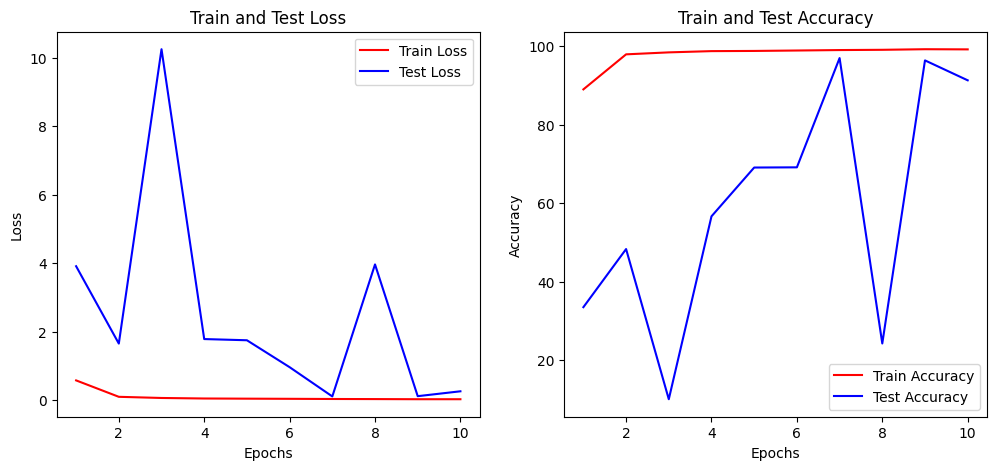

In [3]:
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

# 定义设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 实例化模型并移动到设备上
model = ResNet(ResidualBlock, [2, 2]).to(device)

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练函数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# 评估函数
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# 训练和评估模型
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')
    
epochs = range(1, num_epochs + 1)

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'r-', label='Train Loss')
plt.plot(epochs, test_losses, 'b-', label='Test Loss')
plt.title('Train and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'r-', label='Train Accuracy')
plt.plot(epochs, test_accuracies, 'b-', label='Test Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()